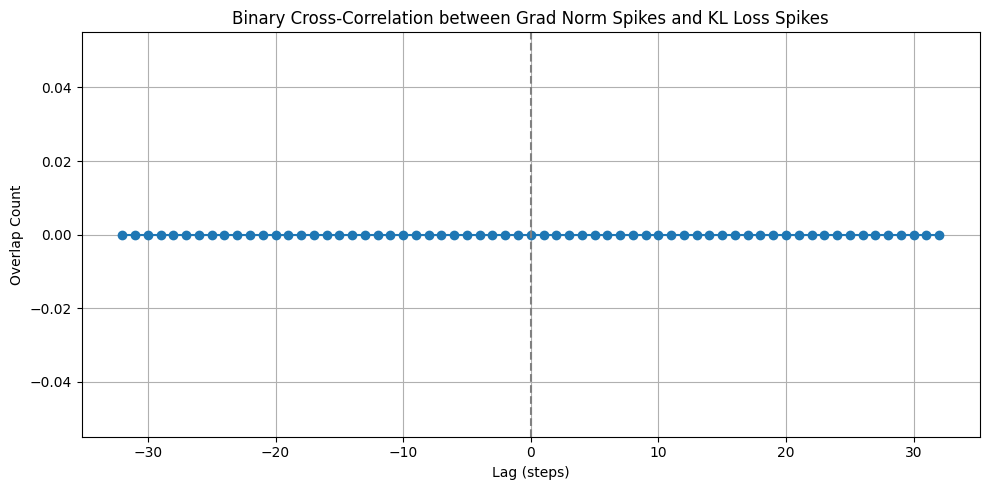

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Load data
grad_df = pd.read_csv('Long Critic Reward Mean.csv')
kl_df = pd.read_csv('Actor Entropy Loss.csv')

# Extract the second column (assumed to be the metric)
grad_series = grad_df.iloc[:, 1]
kl_series = kl_df.iloc[:, 1]

# Remove NaNs
valid = grad_series.notna() & kl_series.notna()
grad_series = grad_series[valid].reset_index(drop=True)
kl_series = kl_series[valid].reset_index(drop=True)

# Define spikes: values greater than mean + 2*std
grad_threshold = grad_series.mean() + 2 * grad_series.std()
kl_threshold = kl_series.mean() + 2 * kl_series.std()

grad_spikes = (grad_series > grad_threshold).astype(int)
kl_spikes = (kl_series > kl_threshold).astype(int)

# Compute binary cross-correlation
correlation = correlate(grad_spikes, kl_spikes, mode='full')
lags = np.arange(-len(grad_spikes) + 1, len(grad_spikes))

# Plot the cross-correlation
plt.figure(figsize=(10, 5))
plt.plot(lags, correlation, marker='o')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Binary Cross-Correlation between Grad Norm Spikes and KL Loss Spikes")
plt.xlabel("Lag (steps)")
plt.ylabel("Overlap Count")
plt.grid(True)
plt.tight_layout()
plt.show()


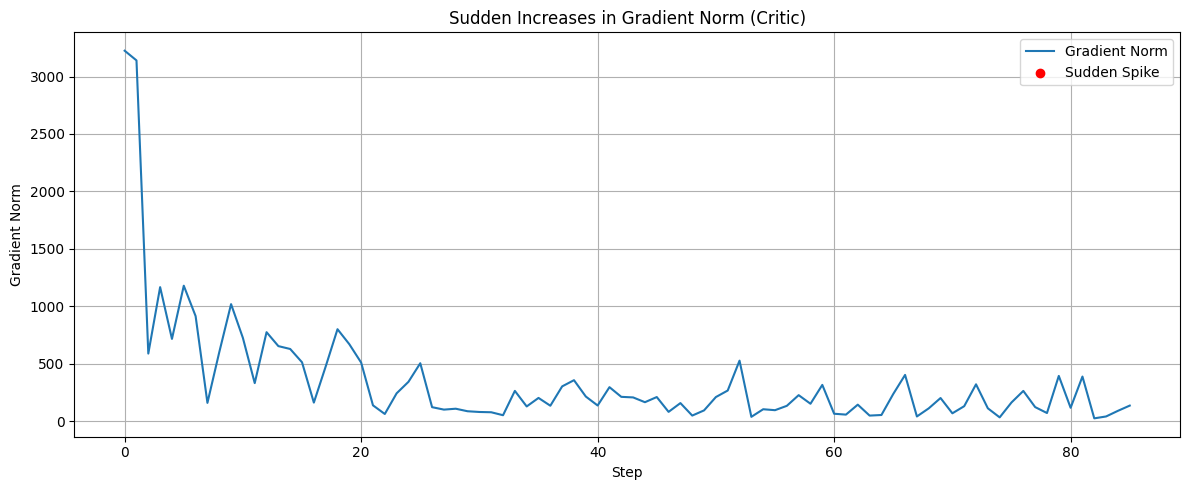

/u/zgao6/miniconda3/envs/ragen/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/zgao6/miniconda3/envs/ragen/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


([], nan)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
grad_df = pd.read_csv('Long Critic Grad Norm.csv')
reward_df = pd.read_csv('Long Critic Reward Mean.csv')

# Extract relevant columns
grad = grad_df.iloc[:, 1]
reward = reward_df.iloc[:, 1]

# Clean and align data
valid = grad.notna() & reward.notna()
grad = grad[valid].reset_index(drop=True)
reward = reward[valid].reset_index(drop=True)

# Compute first-order difference to detect sudden increases (spikes)
grad_diff = grad.diff()
threshold = 1.5 * grad.std()
spike_indices = grad_diff[grad_diff > threshold].index

# Analyze reward change after spike
reward_diff = []
spike_context = []

for idx in spike_indices:
    if idx + 1 < len(reward):
        delta = reward[idx + 1] - reward[idx]
        reward_diff.append(delta)
        segment = reward[max(0, idx - 3):min(len(reward), idx + 4)].values
        spike_context.append((idx, segment))

# Plot the gradient norm with spike points
plt.figure(figsize=(12, 5))
plt.plot(grad, label="Gradient Norm")
plt.scatter(spike_indices, grad[spike_indices], color='red', label="Sudden Spike")
plt.title("Sudden Increases in Gradient Norm (Critic)")
plt.xlabel("Step")
plt.ylabel("Gradient Norm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute average reward change after spikes and return example reward contexts
avg_change = np.mean(reward_diff)
spike_context[:5], avg_change


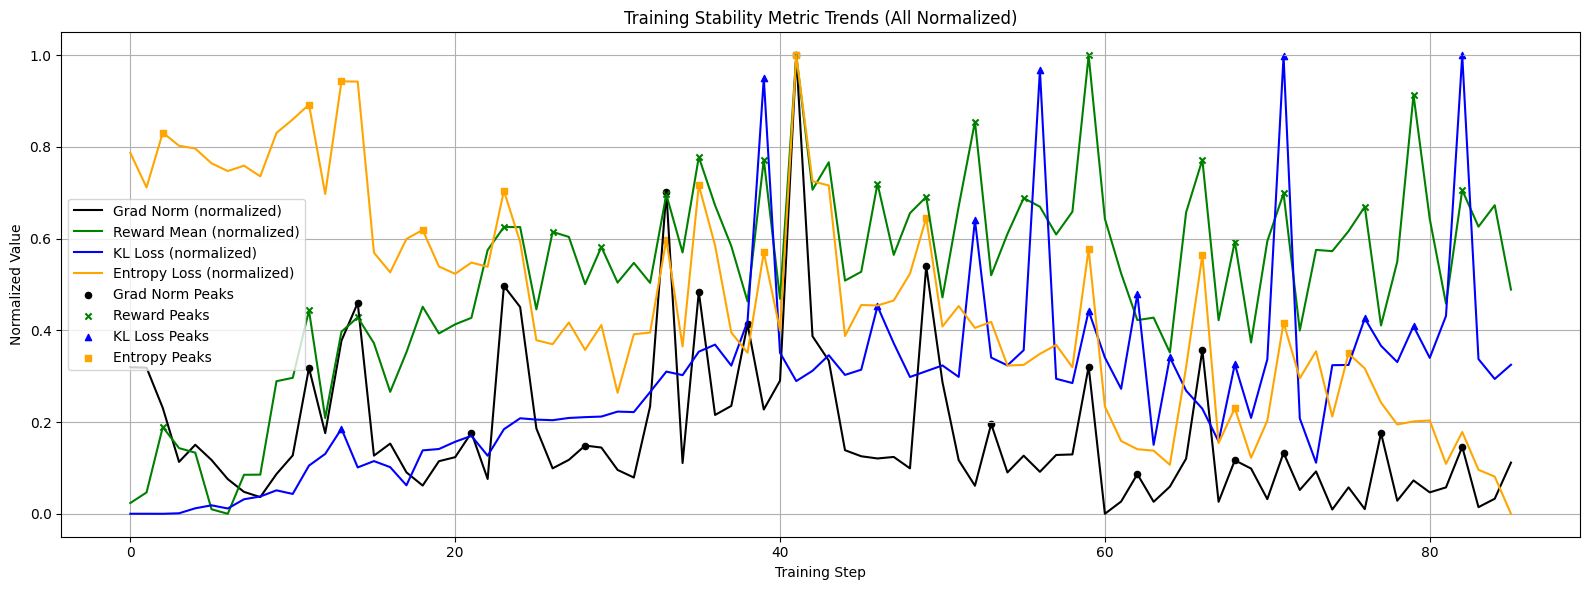

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load data
grad = pd.read_csv("Long Actor Grad Norm.csv").iloc[:, 1].values
reward = pd.read_csv("Long Critic Reward Mean.csv").iloc[:, 1].values
kl = pd.read_csv("Long Actor KL Loss.csv").iloc[:, 1].values
entropy = pd.read_csv("Long Actor Entropy Loss.csv").iloc[:, 1].values

# Normalize all series to [0, 1] for visual comparison
grad_norm = (grad - grad.min()) / (grad.max() - grad.min())
reward_norm = (reward - reward.min()) / (reward.max() - reward.min())
kl_norm = (kl - kl.min()) / (kl.max() - kl.min())
entropy_norm = (entropy - entropy.min()) / (entropy.max() - entropy.min())

# Find spikes
prom_ratio = 0.3
grad_peaks, _ = find_peaks(grad, prominence=np.std(grad) * prom_ratio)
reward_peaks, _ = find_peaks(reward, prominence=np.std(reward) * prom_ratio)
kl_peaks, _ = find_peaks(kl, prominence=np.std(kl) * prom_ratio)
entropy_peaks, _ = find_peaks(entropy, prominence=np.std(entropy) * prom_ratio)

# Plot all in one figure
plt.figure(figsize=(16, 6))
plt.plot(grad_norm, label="Grad Norm (normalized)", color='black')
plt.plot(reward_norm, label="Reward Mean (normalized)", color='green')
plt.plot(kl_norm, label="KL Loss (normalized)", color='blue')
plt.plot(entropy_norm, label="Entropy Loss (normalized)", color='orange')

# Overlay spikes
plt.scatter(grad_peaks, grad_norm[grad_peaks], color='black', s=20, marker='o', label='Grad Norm Peaks')
plt.scatter(reward_peaks, reward_norm[reward_peaks], color='green', s=20, marker='x', label='Reward Peaks')
plt.scatter(kl_peaks, kl_norm[kl_peaks], color='blue', s=20, marker='^', label='KL Loss Peaks')
plt.scatter(entropy_peaks, entropy_norm[entropy_peaks], color='orange', s=20, marker='s', label='Entropy Peaks')

plt.legend()
plt.title("Training Stability Metric Trends (All Normalized)")
plt.xlabel("Training Step")
plt.ylabel("Normalized Value")
plt.grid(True)
plt.tight_layout()
plt.show()


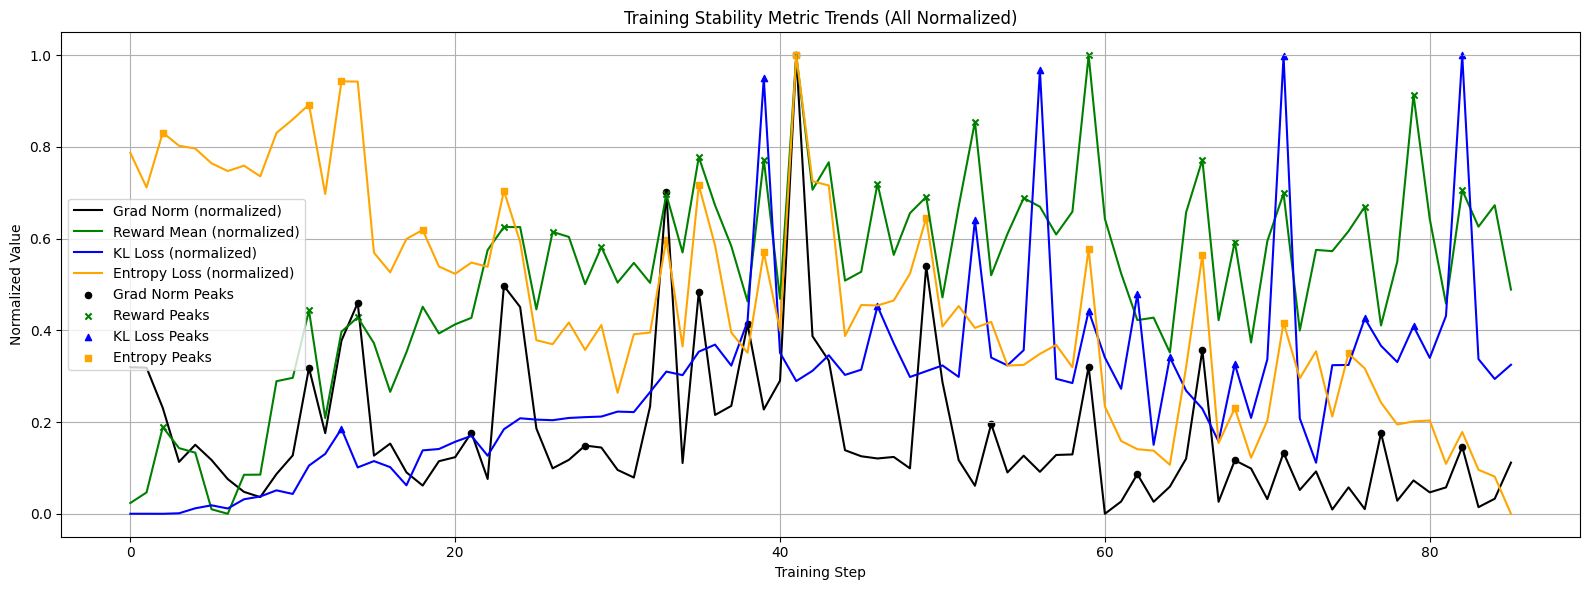

((1.0, 3), (0.9444444444444444, 10), (1.0, 7))

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load data
grad = pd.read_csv("Long Actor Grad Norm.csv").iloc[:, 1].values
reward = pd.read_csv("Long Critic Reward Mean.csv").iloc[:, 1].values
kl = pd.read_csv("Long Actor KL Loss.csv").iloc[:, 1].values
entropy = pd.read_csv("Long Actor Entropy Loss.csv").iloc[:, 1].values

# Normalize all series to [0, 1]
grad_norm = (grad - grad.min()) / (grad.max() - grad.min())
reward_norm = (reward - reward.min()) / (reward.max() - reward.min())
kl_norm = (kl - kl.min()) / (kl.max() - kl.min())
entropy_norm = (entropy - entropy.min()) / (entropy.max() - entropy.min())

# Find spikes
prom_ratio = 0.3
grad_peaks, _ = find_peaks(grad, prominence=np.std(grad) * prom_ratio)
reward_peaks, _ = find_peaks(reward, prominence=np.std(reward) * prom_ratio)
kl_peaks, _ = find_peaks(kl, prominence=np.std(kl) * prom_ratio)
entropy_peaks, _ = find_peaks(entropy, prominence=np.std(entropy) * prom_ratio)

# Compute overlap rates with delay window sweep
def max_overlap_rate(source_peaks, target_peaks, max_window=10):
    best_overlap = 0
    best_window = 0
    for window in range(1, max_window + 1):
        overlap = sum(
            any((target_peaks >= idx - window) & (target_peaks <= idx + window))
            for idx in source_peaks
        )
        rate = overlap / len(source_peaks) if len(source_peaks) > 0 else 0
        if rate > best_overlap:
            best_overlap = rate
            best_window = window
    return best_overlap, best_window

reward_overlap, reward_best_w = max_overlap_rate(grad_peaks, reward_peaks)
kl_overlap, kl_best_w = max_overlap_rate(grad_peaks, kl_peaks)
entropy_overlap, entropy_best_w = max_overlap_rate(grad_peaks, entropy_peaks)

# Plot
plt.figure(figsize=(16, 6))
plt.plot(grad_norm, label="Grad Norm (normalized)", color='black')
plt.plot(reward_norm, label="Reward Mean (normalized)", color='green')
plt.plot(kl_norm, label="KL Loss (normalized)", color='blue')
plt.plot(entropy_norm, label="Entropy Loss (normalized)", color='orange')

# Overlay spikes
plt.scatter(grad_peaks, grad_norm[grad_peaks], color='black', s=20, marker='o', label='Grad Norm Peaks')
plt.scatter(reward_peaks, reward_norm[reward_peaks], color='green', s=20, marker='x', label='Reward Peaks')
plt.scatter(kl_peaks, kl_norm[kl_peaks], color='blue', s=20, marker='^', label='KL Loss Peaks')
plt.scatter(entropy_peaks, entropy_norm[entropy_peaks], color='orange', s=20, marker='s', label='Entropy Peaks')

plt.legend()
plt.title("Training Stability Metric Trends (All Normalized)")
plt.xlabel("Training Step")
plt.ylabel("Normalized Value")
plt.grid(True)
plt.tight_layout()
plt.show()

(reward_overlap, reward_best_w), (kl_overlap, kl_best_w), (entropy_overlap, entropy_best_w)


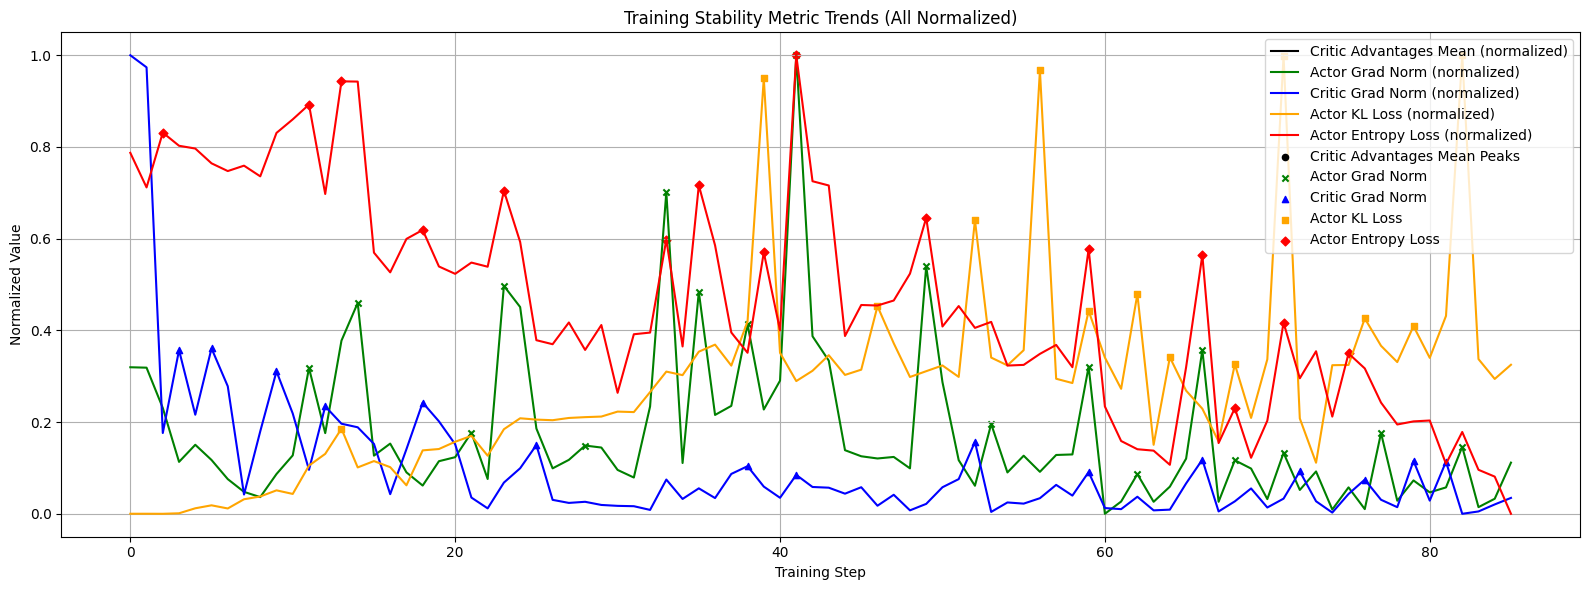

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


((0, 0), (0, 0), (0, 0), (0, 0))

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load data
grad = pd.read_csv("Long Critic Advantage Mean.csv").iloc[:, 1].values
grad = grad.astype(np.float64)
reward = pd.read_csv("Long Actor Grad Norm.csv").iloc[:, 1].values
kl = pd.read_csv("Long Critic Grad Norm.csv").iloc[:, 1].values
entropy = pd.read_csv("Long Actor KL Loss.csv").iloc[:, 1].values
add = pd.read_csv("Long Actor Entropy Loss.csv").iloc[:, 1].values

# Normalize all series to [0, 1]
grad_norm = (grad - grad.min()) / (grad.max() - grad.min())
reward_norm = (reward - reward.min()) / (reward.max() - reward.min())
kl_norm = (kl - kl.min()) / (kl.max() - kl.min())
entropy_norm = (entropy - entropy.min()) / (entropy.max() - entropy.min())
add_norm = (add - add.min()) / (add.max() - add.min())


# Find grad spikes
prom_ratio = 0.3
grad_peaks, _ = find_peaks(grad, prominence=np.std(grad) * prom_ratio)

# Overlap with lag shift
def max_overlap_with_lag(source_peaks, target_series, prom_ratio=0.3, max_lag=5):
    best_rate = 0
    best_shift = 0
    target = target_series.copy()
    for lag in range(-max_lag, max_lag + 1):
        shifted = np.roll(target, lag)
        target_peaks, _ = find_peaks(shifted, prominence=np.std(shifted) * prom_ratio)
        overlap = sum(1 for idx in source_peaks if idx in target_peaks)
        rate = overlap / len(source_peaks) if len(source_peaks) > 0 else 0
        if rate > best_rate:
            best_rate = rate
            best_shift = lag
    return best_rate, best_shift

reward_overlap, reward_best_shift = max_overlap_with_lag(grad_peaks, reward)
kl_overlap, kl_best_shift = max_overlap_with_lag(grad_peaks, kl)
entropy_overlap, entropy_best_shift = max_overlap_with_lag(grad_peaks, entropy)
add_overlap, add_best_shift = max_overlap_with_lag(grad_peaks, add)
# Plot (unchanged)

plt.figure(figsize=(16, 6))
plt.plot(grad_norm, label="Critic Advantages Mean (normalized)", color='black')
plt.plot(reward_norm, label="Actor Grad Norm (normalized)", color='green')
plt.plot(kl_norm, label="Critic Grad Norm (normalized)", color='blue')
plt.plot(entropy_norm, label="Actor KL Loss (normalized)", color='orange')
plt.plot(add_norm, label="Actor Entropy Loss (normalized)", color='red')

plt.scatter(grad_peaks, grad_norm[grad_peaks], color='black', s=20, marker='o', label='Critic Advantages Mean Peaks')
plt.scatter(*zip(*[(i, reward_norm[i]) for i in find_peaks(reward, prominence=np.std(reward) * prom_ratio)[0]]), color='green', s=20, marker='x', label='Actor Grad Norm')
plt.scatter(*zip(*[(i, kl_norm[i]) for i in find_peaks(kl, prominence=np.std(kl) * prom_ratio)[0]]), color='blue', s=20, marker='^', label='Critic Grad Norm')
plt.scatter(*zip(*[(i, entropy_norm[i]) for i in find_peaks(entropy, prominence=np.std(entropy) * prom_ratio)[0]]), color='orange', s=20, marker='s', label='Actor KL Loss')
plt.scatter(*zip(*[(i, add_norm[i]) for i in find_peaks(add, prominence=np.std(add) * prom_ratio)[0]]),
            color='red', s=20, marker='D', label='Actor Entropy Loss')


plt.legend()
plt.title("Training Stability Metric Trends (All Normalized)")
plt.xlabel("Training Step")
plt.ylabel("Normalized Value")
plt.grid(True)
plt.tight_layout()
plt.show()

(reward_overlap, reward_best_shift), (kl_overlap, kl_best_shift), (entropy_overlap, entropy_best_shift),(add_overlap, add_best_shift)


In [7]:
import pandas as pd

# Build table of results
results = {
    "Metric (Actor Side)": ["Entropy Loss", "KL Loss"],
    "Max Overlap Rate vs Critic Reward": [f"{reward_overlap:.1%}", f"{kl_overlap:.1%}"],
    "Best Lag (steps)": [reward_best_shift, kl_best_shift],
}

df = pd.DataFrame(results)

# Display the table
print(df.to_markdown(index=False))


| Metric (Actor Side)   | Max Overlap Rate vs Critic Reward   |   Best Lag (steps) |
|:----------------------|:------------------------------------|-------------------:|
| Entropy Loss          | 57.1%                               |                  0 |
| KL Loss               | 42.9%                               |                  0 |
